In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix
%matplotlib inline

In [2]:
data = pd.read_csv("Train_Test_IOT_Weather.csv")

In [3]:
data.head()

,ts,date,time,temperature,pressure,humidity,label,type
0,1556238796,25-Apr-19,17:33:16,40.881866,-0.101806,38.363631,1,ddos
1,1556238796,25-Apr-19,17:33:16,44.913806,2.661616,46.141423,1,ddos
2,1556238796,25-Apr-19,17:33:16,38.295822,-2.438871,50.850643,1,ddos
3,1556238801,25-Apr-19,17:33:21,41.306586,-0.101806,38.363631,1,ddos
4,1556238801,25-Apr-19,17:33:21,44.903178,3.080849,46.141423,1,ddos


In [4]:
data.drop(columns=['date','time','ts','label'],inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59260 entries, 0 to 59259
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  59260 non-null  float64
 1   pressure     59260 non-null  float64
 2   humidity     59260 non-null  float64
 3   type         59260 non-null  object 
dtypes: float64(3), object(1)
memory usage: 1.6+ MB


In [6]:
data['type'].value_counts()

normal        35000
injection      5000
password       5000
backdoor       5000
ddos           5000
ransomware     2865
xss             866
scanning        529
Name: type, dtype: int64

In [7]:
data.describe()

,temperature,pressure,humidity
count,59260.000000,59260.000000,59260.000000
mean,35.378616,0.892187,48.729767
std,8.332903,2.787494,28.550055
min,20.527012,-12.065426,0.278928
25%,28.209857,0.188713,23.488462
50%,35.773605,1.035000,46.343618
75%,42.243863,1.787000,74.532262
max,50.000000,12.487613,99.875982


In [8]:
data

,temperature,pressure,humidity,type
0,40.881866,-0.101806,38.363631,ddos
1,44.913806,2.661616,46.141423,ddos
2,38.295822,-2.438871,50.850643,ddos
3,41.306586,-0.101806,38.363631,ddos
4,44.903178,3.080849,46.141423,ddos
...,...,...,...,...
59255,32.799434,2.204924,37.024913,normal
59256,29.453781,-2.030547,90.297894,normal
59257,47.185992,0.872942,37.687701,normal
59258,43.097037,3.168207,93.647950,normal


In [9]:
label_type=LabelEncoder()
data['type']=label_type.fit_transform(data['type'])

In [10]:
data['type'].value_counts()

3    35000
4     5000
2     5000
1     5000
0     5000
5     2865
7      866
6      529
Name: type, dtype: int64

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data['type']):
    strat_train = data.loc[train_index]
    strat_test = data.loc[test_index]

In [12]:
strat_train['type'].value_counts()

3    28000
4     4000
2     4000
1     4000
0     4000
5     2292
7      693
6      423
Name: type, dtype: int64

In [13]:
strat_test['type'].value_counts()

3    7000
4    1000
2    1000
1    1000
0    1000
5     573
7     173
6     106
Name: type, dtype: int64

In [14]:
data = strat_train.copy()

In [15]:
corr_matrix = data.corr()

In [16]:
corr_matrix['type'].sort_values(ascending=False)

type           1.000000
pressure       0.138103
temperature   -0.133273
humidity      -0.187966
Name: type, dtype: float64

array([[<AxesSubplot:xlabel='temperature', ylabel='temperature'>,
        <AxesSubplot:xlabel='pressure', ylabel='temperature'>,
        <AxesSubplot:xlabel='humidity', ylabel='temperature'>,
        <AxesSubplot:xlabel='type', ylabel='temperature'>],
       [<AxesSubplot:xlabel='temperature', ylabel='pressure'>,
        <AxesSubplot:xlabel='pressure', ylabel='pressure'>,
        <AxesSubplot:xlabel='humidity', ylabel='pressure'>,
        <AxesSubplot:xlabel='type', ylabel='pressure'>],
       [<AxesSubplot:xlabel='temperature', ylabel='humidity'>,
        <AxesSubplot:xlabel='pressure', ylabel='humidity'>,
        <AxesSubplot:xlabel='humidity', ylabel='humidity'>,
        <AxesSubplot:xlabel='type', ylabel='humidity'>],
       [<AxesSubplot:xlabel='temperature', ylabel='type'>,
        <AxesSubplot:xlabel='pressure', ylabel='type'>,
        <AxesSubplot:xlabel='humidity', ylabel='type'>,
        <AxesSubplot:xlabel='type', ylabel='type'>]], dtype=object)

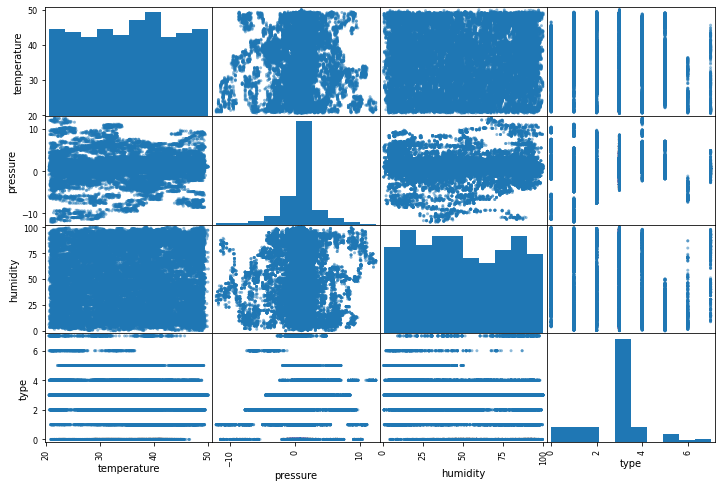

In [17]:
scatter_matrix(data, figsize=(12, 8))

In [18]:
##pipeline creation

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
my_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

##Numpy array output 
data_num = my_pipe.fit_transform(data)
data_num.shape

(47408, 4)

In [19]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

##prepare for training
x = data.drop('type', axis = 1)
y = data['type'].copy()

X =my_pipe.fit_transform(x)

classifier = SVC(kernel="rbf", random_state = 1)
#classifier.fit(X_train,Y_train)

cv = KFold(n_splits=10, shuffle=True, random_state=1)
n_scores=cross_val_score(classifier, X, y, scoring='accuracy', cv=cv, n_jobs=1, error_score='raise')
print('Accuracy: %3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.741014 (0.006)


In [20]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.1,1,10],'kernel':['rbf'],'gamma':[1,0.1]}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
grid.fit(X,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.760, total= 1.2min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.750, total= 1.2min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.750, total= 1.2min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.750, total= 1.1min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.757, total= 1.1min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.681, total= 1.7min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.677, total= 1.7min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.683, total= 1.7min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.675, total= 1.6min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 35.5min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1],
                         'kernel': ['rbf']},
             verbose=3)

In [21]:
grid.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [22]:
grid.best_estimator_

SVC(C=10, gamma=1)

In [28]:
X_test = strat_test.drop('type', axis=1)
x_test = my_pipe.fit_transform(X_test)
y_test = strat_test['type'].copy()

In [29]:
model1 = SVC(C=10, gamma=1, kernel="rbf", random_state = 1)
model1.fit(x_test,y_test)

SVC(C=10, gamma=1, random_state=1)

In [30]:
model1.score(x_test,y_test)

0.8059399257509281

In [31]:
y_pred = model1.predict(x_test)

In [32]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.49      0.60      1000
           1       0.87      0.56      0.68      1000
           2       0.92      0.75      0.83      1000
           3       0.79      0.97      0.87      7000
           4       0.82      0.59      0.68      1000
           5       0.81      0.38      0.52       573
           6       0.99      0.92      0.96       106
           7       0.92      0.35      0.50       173

    accuracy                           0.81     11852
   macro avg       0.86      0.63      0.71     11852
weighted avg       0.81      0.81      0.79     11852



In [33]:
cm = metrics.confusion_matrix(y_test, y_pred)

<AxesSubplot:>

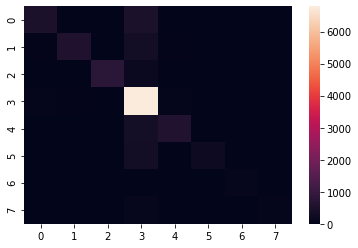

In [34]:
import seaborn as sns 
sns.heatmap(cm)

In [35]:
cm

array([[ 493,    7,    0,  493,    4,    0,    0,    3],
       [  40,  562,   17,  331,   37,   13,    0,    0],
       [  17,   14,  748,  207,    9,    4,    1,    0],
       [  64,   28,   24, 6787,   71,   24,    0,    2],
       [  17,   13,    9,  365,  587,    9,    0,    0],
       [   0,   19,    9,  323,    5,  217,    0,    0],
       [   0,    0,    6,    2,    0,    0,   98,    0],
       [   1,    0,    0,  106,    6,    0,    0,   60]], dtype=int64)